### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import masserstein 

In [3]:
import os

from masserstein import Spectrum, NMRSpectrum, estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

import seaborn as sns

from textwrap import wrap

### Ground truth

In [4]:
protons = [16, 12]

In [5]:
molar_proportions = [0.3865, 0.6135]

In [6]:
real_visible_proportions = [prop*prot for prop, prot in zip(molar_proportions, protons)]
real_visible_proportions = [rp/sum(real_visible_proportions) for rp in real_visible_proportions]
real_visible_proportions

[0.4565185294551898, 0.5434814705448103]

### Loading the data

In [7]:
official_names = ['Pinene', 'Benzyl_benzoate']

In [8]:
# ppm = #np.array with shape (number_of_points on frequency axis for mixture,)
# mix = #np.array with shape (number_of_points on frequency axis,)
# ppm_comp = #np.array with shape (number_of_points on frequency axis for components, )
# components = #np.array with shape (number_of_points on frequency axis for components, number of components)
# real_visible_proportions = #np.array with shape (number of components,)

In [9]:
data = np.loadtxt(os.getcwd()+'/mini_perfumy_duze_pole_CDCl3.csv', skiprows=1, usecols=range(5),
                      delimiter='\t',dtype=float)
ppm = data[:,0]
mix = data[:,4]
ppm_components = data[:,0]
components = data[:,1:3]

In [10]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [11]:
spectra = []
for i, comp_ints in enumerate(components_ints):
    spectra.append(NMRSpectrum(confs=list(zip(ppm_components, comp_ints)), protons=protons[i]))

In [12]:
mix = NMRSpectrum(confs=list(zip(ppm,mix)))

### Preprocessing

In [13]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = NMRSpectrum(confs=new_confs)
    return(result)

In [14]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [15]:
spectra_and_mixture = spectra + [mix]

In [16]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [17]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [18]:
cma = common_mass_axis(spectra_and_mixture)

In [19]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [20]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [21]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [22]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [23]:
for i, sp in enumerate(spectra):
    sp.protons = protons[i]

In [24]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [25]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [26]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

<IPython.core.display.Javascript object>


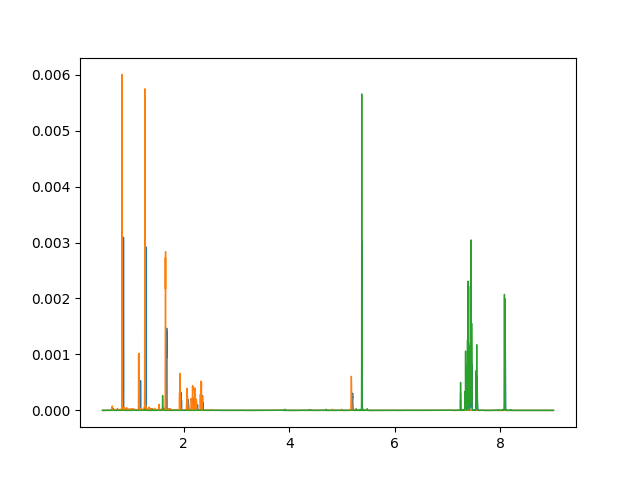

In [27]:
mix.plot(profile=True)
comp0.plot(profile=True)
comp1.plot(profile=True) 

### Finding best parameters

In [28]:
import time
import pandas as pd
import pulp

In [29]:
lower_limit = 0.01
upper_limit = 0.31
step = 0.01

In [32]:
# list_of_estimation_results = []
# for kappa in np.arange(start=lower_limit, stop=upper_limit, step=step):
#     fixed_kappa = []
#     for kappa_prime in np.arange(start=lower_limit, stop=upper_limit, step=step):
#         start = time.time()
#         estimation = estimate_proportions(mix, [comp0, comp1], 
#                                    MTD=kappa, MTD_th=kappa_prime, verbose=False, solver=pulp.GUROBI(msg=False),
#                                     what_to_compare='area')
#         end = time.time()
#         fixed_kappa.append(estimation['proportions'])
#         print('Estimation for '+str(kappa)+' and '+str(kappa_prime)+' done')
#         print('It took: '+str(end-start)+' seconds.')
#         print(estimation['proportions'])
#     list_of_estimation_results.append(fixed_kappa)

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2023-11-10


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estimation for 0.01 and 0.01 done
It took: 51.42900109291077 seconds.
[0.025579499933999994, 0.5259602004659999]
Estimation for 0.01 and 0.02 done
It took: 57.32509708404541 seconds.
[0.008549269307999999, 0.5109137827889999]
Estimation for 0.01 and 0.03 done
It took: 62.890963077545166 seconds.
[0.008430950665999998, 0.5097136963619999]
Estimation for 0.01 and 0.04 done
It took: 57.48659634590149 seconds.
[0.008164710573999999, 0.5082119510999998]
Estimation for 0.01 and 0.05 done
It took: 58.07193470001221 seconds.
[0.008098468997999998, 0.5078445813769998]
Estimation for 0.01 and 0.060000000000000005 done
It took: 62.413915395736694 seconds.
[0.007939365642999999, 0.5067683456759999]
Estimation for 0.01 and 0.06999999999999999 done
It took: 55.24649739265442 seconds.
[0.007787650965999998, 0.5056325170639999]
Estimation for 0.01 and 0.08 done
It took: 60.46590805053711 seconds.
[0.007639029820999998, 0.5046885605149999]
Estimation for 0.01 and 0.09 done
It took: 70.37538146972656 se

Estimation for 0.03 and 0.12 done
It took: 50.14647626876831 seconds.
[0.4191707313299999, 0.5339403436089999]
Estimation for 0.03 and 0.13 done
It took: 52.282068490982056 seconds.
[0.4178660628919999, 0.5346411334039999]
Estimation for 0.03 and 0.14 done
It took: 52.20691728591919 seconds.
[0.4170162819799999, 0.5360507738089999]
Estimation for 0.03 and 0.15000000000000002 done
It took: 52.32126021385193 seconds.
[0.4160250104469999, 0.5360510610719998]
Estimation for 0.03 and 0.16 done
It took: 51.483487367630005 seconds.
[0.4141014451159999, 0.5359065544799999]
Estimation for 0.03 and 0.17 done
It took: 52.96867871284485 seconds.
[0.4125323880729999, 0.5344456871529999]
Estimation for 0.03 and 0.18000000000000002 done
It took: 51.95543122291565 seconds.
[0.4133320368829999, 0.5245585095839999]
Estimation for 0.03 and 0.19 done
It took: 50.279653549194336 seconds.
[0.4126391012619999, 0.5244048217339999]
Estimation for 0.03 and 0.2 done
It took: 50.99709463119507 seconds.
[0.4119483

Estimation for 0.05 and 0.23 done
It took: 53.47296905517578 seconds.
[0.44271722482499987, 0.5327892772799999]
Estimation for 0.05 and 0.24000000000000002 done
It took: 53.031994581222534 seconds.
[0.4427244290089999, 0.5327574498049998]
Estimation for 0.05 and 0.25 done
It took: 53.967008113861084 seconds.
[0.4427100511999999, 0.5327565483789999]
Estimation for 0.05 and 0.26 done
It took: 52.63112115859985 seconds.
[0.4426868234189999, 0.5327464914249999]
Estimation for 0.05 and 0.27 done
It took: 51.99279522895813 seconds.
[0.4426812833279999, 0.5327447627799999]
Estimation for 0.05 and 0.28 done
It took: 53.52180290222168 seconds.
[0.4426678025859999, 0.5327420214999999]
Estimation for 0.05 and 0.29000000000000004 done
It took: 51.08245491981506 seconds.
[0.4426607694039999, 0.5327349179839999]
Estimation for 0.05 and 0.3 done
It took: 51.72413969039917 seconds.
[0.44266839794899987, 0.5327187924519999]
Estimation for 0.060000000000000005 and 0.01 done
It took: 49.028494358062744 s

Estimation for 0.06999999999999999 and 0.27 done
It took: 48.77698373794556 seconds.
[0.4534483898029999, 0.5326191390449999]
Estimation for 0.06999999999999999 and 0.28 done
It took: 49.40936064720154 seconds.
[0.45342653232199986, 0.5326189635259999]
Estimation for 0.06999999999999999 and 0.29000000000000004 done
It took: 49.35956048965454 seconds.
[0.4534167990339999, 0.5326168887559999]
Estimation for 0.06999999999999999 and 0.3 done
It took: 51.73298764228821 seconds.
[0.45342479228299987, 0.5326069863249999]
Estimation for 0.08 and 0.01 done
It took: 49.18949818611145 seconds.
[0.6434072034759999, 0.35659279652399994]
Estimation for 0.08 and 0.02 done
It took: 53.090312480926514 seconds.
[0.4888609706039999, 0.5107580177689999]
Estimation for 0.08 and 0.03 done
It took: 49.3897168636322 seconds.
[0.4694747478619999, 0.5288268633069999]
Estimation for 0.08 and 0.04 done
It took: 51.05909538269043 seconds.
[0.46633498682199986, 0.5317964667869999]
Estimation for 0.08 and 0.05 done


Estimation for 0.09999999999999999 and 0.06999999999999999 done
It took: 47.457865715026855 seconds.
[0.4632702554539999, 0.5340205171829999]
Estimation for 0.09999999999999999 and 0.08 done
It took: 52.436153173446655 seconds.
[0.4629580126989999, 0.5342169084729999]
Estimation for 0.09999999999999999 and 0.09 done
It took: 51.631558656692505 seconds.
[0.4627524034999999, 0.5344110203509999]
Estimation for 0.09999999999999999 and 0.09999999999999999 done
It took: 50.08019995689392 seconds.
[0.4623722471529999, 0.5346491975779999]
Estimation for 0.09999999999999999 and 0.11 done
It took: 51.77721929550171 seconds.
[0.4611859333259999, 0.5350005748019999]
Estimation for 0.09999999999999999 and 0.12 done
It took: 51.65765905380249 seconds.
[0.46111271219599986, 0.5349893454319999]
Estimation for 0.09999999999999999 and 0.13 done
It took: 49.81673049926758 seconds.
[0.4611285198639999, 0.5349038375239998]
Estimation for 0.09999999999999999 and 0.14 done
It took: 51.119225025177 seconds.
[

Estimation for 0.12 and 0.15000000000000002 done
It took: 50.58552837371826 seconds.
[0.4614813751489999, 0.5349635873939999]
Estimation for 0.12 and 0.16 done
It took: 49.332470178604126 seconds.
[0.4614352889239999, 0.5349417890889999]
Estimation for 0.12 and 0.17 done
It took: 50.239802837371826 seconds.
[0.4614314199269999, 0.5348885205739999]
Estimation for 0.12 and 0.18000000000000002 done
It took: 52.40572476387024 seconds.
[0.4612691269629999, 0.5349137383859999]
Estimation for 0.12 and 0.19 done
It took: 52.598742961883545 seconds.
[0.4610461597499999, 0.5349816485079999]
Estimation for 0.12 and 0.2 done
It took: 52.54135727882385 seconds.
[0.4607992379919999, 0.5350109685319999]
Estimation for 0.12 and 0.21000000000000002 done
It took: 52.07317662239075 seconds.
[0.4604863950519999, 0.5349589460289998]
Estimation for 0.12 and 0.22 done
It took: 49.6626033782959 seconds.
[0.46042762519199987, 0.5346975388939998]
Estimation for 0.12 and 0.23 done
It took: 52.226980209350586 sec

Estimation for 0.14 and 0.26 done
It took: 51.43919539451599 seconds.
[0.4616505882559999, 0.5316323772229999]
Estimation for 0.14 and 0.27 done
It took: 50.253472089767456 seconds.
[0.46143623151699986, 0.5316926196059999]
Estimation for 0.14 and 0.28 done
It took: 50.97296905517578 seconds.
[0.4611157523239999, 0.5317785959129999]
Estimation for 0.14 and 0.29000000000000004 done
It took: 48.43539500236511 seconds.
[0.4605249486859999, 0.5319679441339998]
Estimation for 0.14 and 0.3 done
It took: 51.221293210983276 seconds.
[0.4594298149179999, 0.5323572528089999]
Estimation for 0.15000000000000002 and 0.01 done
It took: 44.56133985519409 seconds.
[0.6434072034759999, 0.35659279652399994]
Estimation for 0.15000000000000002 and 0.02 done
It took: 56.60826015472412 seconds.
[0.4893708334239999, 0.5103717788399998]
Estimation for 0.15000000000000002 and 0.03 done
It took: 55.19926595687866 seconds.
[0.47232331111999987, 0.5271627000729999]
Estimation for 0.15000000000000002 and 0.04 done

Estimation for 0.17 and 0.04 done
It took: 52.65487837791443 seconds.
[0.46855174615599987, 0.5309205175469999]
Estimation for 0.17 and 0.05 done
It took: 53.15677046775818 seconds.
[0.4675409358609999, 0.5318519009299999]
Estimation for 0.17 and 0.060000000000000005 done
It took: 49.9331271648407 seconds.
[0.4674490215049999, 0.5319264197429999]
Estimation for 0.17 and 0.06999999999999999 done
It took: 53.650012731552124 seconds.
[0.4673106817069999, 0.5320288726279999]
Estimation for 0.17 and 0.08 done
It took: 52.47525238990784 seconds.
[0.46661539298799987, 0.5324305249049999]
Estimation for 0.17 and 0.09 done
It took: 52.017742395401 seconds.
[0.4649768092429999, 0.5333370082629999]
Estimation for 0.17 and 0.09999999999999999 done
It took: 53.51906442642212 seconds.
[0.4635493226559999, 0.5341302431209999]
Estimation for 0.17 and 0.11 done
It took: 48.93780541419983 seconds.
[0.4633002919049999, 0.5342674559419999]
Estimation for 0.17 and 0.12 done
It took: 51.38297510147095 secon

Estimation for 0.19 and 0.12 done
It took: 48.90534853935242 seconds.
[0.4633779736349999, 0.5342507567829999]
Estimation for 0.19 and 0.13 done
It took: 53.046366453170776 seconds.
[0.4632666870119999, 0.5343413130039999]
Estimation for 0.19 and 0.14 done
It took: 51.94503140449524 seconds.
[0.4631010135309999, 0.5343893904909999]
Estimation for 0.19 and 0.15000000000000002 done
It took: 51.54192662239075 seconds.
[0.4628456136299999, 0.5345122483909999]
Estimation for 0.19 and 0.16 done
It took: 49.7405731678009 seconds.
[0.4626024849099999, 0.5346155325939999]
Estimation for 0.19 and 0.17 done
It took: 50.578755140304565 seconds.
[0.4624778833299999, 0.5346571308659999]
Estimation for 0.19 and 0.18000000000000002 done
It took: 51.98055386543274 seconds.
[0.4620121920119999, 0.5348319862469999]
Estimation for 0.19 and 0.19 done
It took: 51.30956840515137 seconds.
[0.4617872581589999, 0.5349353071769999]
Estimation for 0.19 and 0.2 done
It took: 51.03855872154236 seconds.
[0.461744623

Estimation for 0.21000000000000002 and 0.21000000000000002 done
It took: 54.8332998752594 seconds.
[0.4617917521899999, 0.5349814020509999]
Estimation for 0.21000000000000002 and 0.22 done
It took: 50.06310749053955 seconds.
[0.46176979515099986, 0.5349895005729999]
Estimation for 0.21000000000000002 and 0.23 done
It took: 50.507529497146606 seconds.
[0.4617461892679999, 0.5350140853219999]
Estimation for 0.21000000000000002 and 0.24000000000000002 done
It took: 52.52081632614136 seconds.
[0.4617506884149999, 0.5351337027629999]
Estimation for 0.21000000000000002 and 0.25 done
It took: 53.46921730041504 seconds.
[0.4617964075879999, 0.5352231492589999]
Estimation for 0.21000000000000002 and 0.26 done
It took: 53.714741230010986 seconds.
[0.46182916968299986, 0.5350308826319999]
Estimation for 0.21000000000000002 and 0.27 done
It took: 52.64771628379822 seconds.
[0.4618547809819999, 0.5347618736689999]
Estimation for 0.21000000000000002 and 0.28 done
It took: 49.68264150619507 seconds.


Estimation for 0.24000000000000002 and 0.01 done
It took: 64.69148015975952 seconds.
[0.6434072034759999, 0.35659279652399994]
Estimation for 0.24000000000000002 and 0.02 done
It took: 51.02085328102112 seconds.
[0.4900386908749999, 0.5098904235189999]
Estimation for 0.24000000000000002 and 0.03 done
It took: 50.392303466796875 seconds.
[0.4732543599799999, 0.5265172700119999]
Estimation for 0.24000000000000002 and 0.04 done
It took: 53.60685920715332 seconds.
[0.4694607519479999, 0.5302293504979999]
Estimation for 0.24000000000000002 and 0.05 done
It took: 53.70281386375427 seconds.
[0.4678242598609999, 0.5317155399559998]
Estimation for 0.24000000000000002 and 0.060000000000000005 done
It took: 51.97861051559448 seconds.
[0.4676939142719999, 0.5318100068569999]
Estimation for 0.24000000000000002 and 0.06999999999999999 done
It took: 48.18852996826172 seconds.
[0.4675675721169999, 0.5319088371159999]
Estimation for 0.24000000000000002 and 0.08 done
It took: 50.336965799331665 seconds.

Estimation for 0.26 and 0.09 done
It took: 48.47149896621704 seconds.
[0.46743946568099987, 0.5319957651629998]
Estimation for 0.26 and 0.09999999999999999 done
It took: 51.60292959213257 seconds.
[0.4673569350489999, 0.5320552264589999]
Estimation for 0.26 and 0.11 done
It took: 50.348496198654175 seconds.
[0.46708038859399986, 0.5322664896369999]
Estimation for 0.26 and 0.12 done
It took: 48.95560908317566 seconds.
[0.4664778397409999, 0.5325918386559999]
Estimation for 0.26 and 0.13 done
It took: 49.620808124542236 seconds.
[0.4649093671859999, 0.5334905664469999]
Estimation for 0.26 and 0.14 done
It took: 50.54568290710449 seconds.
[0.46420795308399987, 0.5339242978749998]
Estimation for 0.26 and 0.15000000000000002 done
It took: 51.527965784072876 seconds.
[0.46389007502899987, 0.5341419393699999]
Estimation for 0.26 and 0.16 done
It took: 49.332794189453125 seconds.
[0.46374476707899986, 0.5342564051139999]
Estimation for 0.26 and 0.17 done
It took: 51.68953275680542 seconds.
[0.

Estimation for 0.28 and 0.2 done
It took: 53.61921143531799 seconds.
[0.46345022460399987, 0.5345039298899998]
Estimation for 0.28 and 0.21000000000000002 done
It took: 51.4840521812439 seconds.
[0.46311521750899987, 0.5346849052019998]
Estimation for 0.28 and 0.22 done
It took: 53.70075249671936 seconds.
[0.4629339872049999, 0.5347866250509999]
Estimation for 0.28 and 0.23 done
It took: 51.459349632263184 seconds.
[0.46227397761099986, 0.5351488851739999]
Estimation for 0.28 and 0.24000000000000002 done
It took: 50.71741056442261 seconds.
[0.4621293965629999, 0.5352270876469999]
Estimation for 0.28 and 0.25 done
It took: 51.48432278633118 seconds.
[0.4620909459839999, 0.5352596130309999]
Estimation for 0.28 and 0.26 done
It took: 50.02645421028137 seconds.
[0.4620690504799999, 0.5352812660079999]
Estimation for 0.28 and 0.27 done
It took: 50.224663734436035 seconds.
[0.4619873028019999, 0.5353317856809999]
Estimation for 0.28 and 0.28 done
It took: 52.84314966201782 seconds.
[0.461951

Estimation for 0.3 and 0.28 done
It took: 52.08792543411255 seconds.
[0.4620030823189999, 0.5353421426819999]
Estimation for 0.3 and 0.29000000000000004 done
It took: 51.562994956970215 seconds.
[0.4619634879339999, 0.5353333395099998]
Estimation for 0.3 and 0.3 done
It took: 53.179272413253784 seconds.
[0.4618898331909999, 0.5353321718429999]


In [33]:
# list_of_dataframes_with_results = []
# for component_number in range(len([comp0, comp1])):
#     results_for_component = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
#                                    index=np.arange(start=lower_limit, stop=upper_limit, step=step))
#     for i in range(results_for_component.shape[0]):
#         for j in range(results_for_component.shape[1]):
#             results_for_component.iloc[i,j] = list_of_estimation_results[i][j][component_number]
    
#     list_of_dataframes_with_results.append(results_for_component)

In [34]:
# with open('results_for_different_kappas.pkl', 'wb') as f:
#     pickle.dump(list_of_dataframes_with_results, f)

#### Molar proportions

In [30]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [31]:
temp = []
for nr_of_component, df in enumerate(list_of_dataframes_with_results):
    temp.append(df/protons[nr_of_component])
temp2 = []
for df in temp:
    temp2.append(df/sum(temp))
list_of_dataframes_with_results = temp2
del(temp)
del(temp2)

In [32]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - molar_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [33]:
all_components_results_molar = sum(dataframes_ready_for_heatmap)

#### Visible proportions

In [34]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [35]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - real_visible_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [36]:
all_components_results_vis = sum(dataframes_ready_for_heatmap)

#### Both

In [37]:
all_components_results_both = all_components_results_vis + all_components_results_molar

In [38]:
all_components_results_both = all_components_results_both.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [39]:
all_components_results_both.min().min()

0.014947790315881448

In [40]:
all_components_results_both[0.2][0.060000000000000005]

0.014947790315881448

### Saving preprocessed spectra

In [41]:
# for i, sp in enumerate(spectra_and_mixture):
#     try:
#         np.savetxt('preprocessed_'+str(names[i])+'.csv', np.array(sp.confs), delimiter=',')
#     except IndexError:
#         np.savetxt('preprocessed_mix.csv', np.array(sp.confs), delimiter=',')